In [81]:
import os
import shutil
import tempfile
import glob
import pandas as pd
import nibabel as nib
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import monai


from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.data import decollate_batch, partition_dataset_classes, NibabelReader, DataLoader, Dataset
from monai.networks.nets import DenseNet121
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    Resize,
    ResizeWithPadOrCropd,
    ScaleIntensity,
    ToTensor,
    Activations,
    AsDiscrete,
    EnsureType,
    Pad,
    SpatialCrop,
    CenterSpatialCrop
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.0.1
Numpy version: 1.23.5
Pytorch version: 1.12.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /home/ubuntu/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.13.0
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.0.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [82]:
torch.__version__

'1.12.0'

In [83]:
set_determinism(seed=0)

In [84]:
!nvidia-smi

Tue Dec 13 01:40:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   38C    P0    25W /  70W |    601MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [86]:
os.getcwd()

'/home/ubuntu/code'

In [87]:
data_dir = '/home/ubuntu/data/nifti'

# csv

In [88]:
mgmt_df = pd.read_csv('/home/ubuntu/data/csv/mgmt_df_for_image_cls.csv' )

In [89]:
mgmt_df.columns

Index(['ID', 'Age at MRI', 'WHO CNS Grade', 'MGMT index', '1-dead 0-alive',
       'OS', 'Sex_F', 'Final pathologic diagnosis_Astrocytoma, IDH-mutant',
       'Final pathologic diagnosis_Astrocytoma, IDH-wildtype',
       'Final pathologic diagnosis_Glioblastoma, IDH-wildtype',
       'Final pathologic diagnosis_Oligodendroglioma, IDH-mutant, 1p/19q-codeleted',
       'MGMT status_indeterminate', 'MGMT status_negative',
       'MGMT status_positive', 'MGMT status_nan', '1p/19q_co-deletion',
       '1p/19q_intact', '1p/19q_relative co-deletion', '1p/19q_nan',
       'IDH_IDH1 p.Arg132His', 'IDH_IDH1 p.R132C', 'IDH_IDH1 p.R132G',
       'IDH_IDH1 p.R132H', 'IDH_IDH1 p.R132S', 'IDH_IDH2 p.Arg172Trp',
       'IDH_IDH2 p.R172K', 'IDH_mutated (NOS)', 'IDH_wildtype', 'EOR_GTR',
       'EOR_STR', 'EOR_biopsy', 'EOR_nan', 'biopsy_No', 'biopsy_Yes'],
      dtype='object')

In [90]:
mgmt_df[['ID', 'MGMT status_negative',
       'MGMT status_positive']]

,ID,MGMT status_negative,MGMT status_positive
0,UCSF-PDGM-004,1,0
1,UCSF-PDGM-008,1,0
2,UCSF-PDGM-009,1,0
3,UCSF-PDGM-010,0,1
4,UCSF-PDGM-011,0,1
...,...,...,...
410,UCSF-PDGM-537,0,1
411,UCSF-PDGM-538,1,0
412,UCSF-PDGM-539,0,1
413,UCSF-PDGM-540,0,1


In [91]:
(mgmt_df['MGMT status_positive'] == 1).sum()

301

In [92]:
mgmt_pos_ids = mgmt_df[mgmt_df['MGMT status_positive'] == 1]['ID'].tolist()
mgmt_neg_ids = mgmt_df[mgmt_df['MGMT status_negative'] == 1]['ID'].tolist()


In [93]:
mgmt_df[['ID', 'MGMT status_negative',
       'MGMT status_positive']]

,ID,MGMT status_negative,MGMT status_positive
0,UCSF-PDGM-004,1,0
1,UCSF-PDGM-008,1,0
2,UCSF-PDGM-009,1,0
3,UCSF-PDGM-010,0,1
4,UCSF-PDGM-011,0,1
...,...,...,...
410,UCSF-PDGM-537,0,1
411,UCSF-PDGM-538,1,0
412,UCSF-PDGM-539,0,1
413,UCSF-PDGM-540,0,1


In [94]:
def create_file_path(id_list, verbose = False):
    
    # add zero to id list
    for i, id in enumerate(id_list):
        id_list[i] = id[:-3] + '0' + id[-3:]

    image_files_list = []
    # add file path
    for i in id_list:
        file = '/' + i +'_T1c.nii.gz' #, recursive = True)
        if verbose:
            print(file)
        image_files_list.append(file)

    return image_files_list

image_pos_file_list = create_file_path(mgmt_pos_ids)
image_neg_file_list = create_file_path(mgmt_neg_ids)

In [95]:
len(image_pos_file_list)

301

In [96]:
len(image_neg_file_list)

114

In [97]:
image_pos_file_list

['/UCSF-PDGM-0010_T1c.nii.gz',
 '/UCSF-PDGM-0011_T1c.nii.gz',
 '/UCSF-PDGM-0013_T1c.nii.gz',
 '/UCSF-PDGM-0014_T1c.nii.gz',
 '/UCSF-PDGM-0016_T1c.nii.gz',
 '/UCSF-PDGM-0018_T1c.nii.gz',
 '/UCSF-PDGM-0019_T1c.nii.gz',
 '/UCSF-PDGM-0021_T1c.nii.gz',
 '/UCSF-PDGM-0022_T1c.nii.gz',
 '/UCSF-PDGM-0023_T1c.nii.gz',
 '/UCSF-PDGM-0024_T1c.nii.gz',
 '/UCSF-PDGM-0025_T1c.nii.gz',
 '/UCSF-PDGM-0026_T1c.nii.gz',
 '/UCSF-PDGM-0030_T1c.nii.gz',
 '/UCSF-PDGM-0031_T1c.nii.gz',
 '/UCSF-PDGM-0033_T1c.nii.gz',
 '/UCSF-PDGM-0035_T1c.nii.gz',
 '/UCSF-PDGM-0036_T1c.nii.gz',
 '/UCSF-PDGM-0037_T1c.nii.gz',
 '/UCSF-PDGM-0038_T1c.nii.gz',
 '/UCSF-PDGM-0039_T1c.nii.gz',
 '/UCSF-PDGM-0040_T1c.nii.gz',
 '/UCSF-PDGM-0043_T1c.nii.gz',
 '/UCSF-PDGM-0044_T1c.nii.gz',
 '/UCSF-PDGM-0045_T1c.nii.gz',
 '/UCSF-PDGM-0047_T1c.nii.gz',
 '/UCSF-PDGM-0048_T1c.nii.gz',
 '/UCSF-PDGM-0049_T1c.nii.gz',
 '/UCSF-PDGM-0050_T1c.nii.gz',
 '/UCSF-PDGM-0053_T1c.nii.gz',
 '/UCSF-PDGM-0055_T1c.nii.gz',
 '/UCSF-PDGM-0056_T1c.nii.gz',
 '/UCSF-

In [98]:
# create full list
image_files_list = image_pos_file_list.copy()
image_files_list.extend(image_neg_file_list)

In [99]:
image_files_list


['/UCSF-PDGM-0010_T1c.nii.gz',
 '/UCSF-PDGM-0011_T1c.nii.gz',
 '/UCSF-PDGM-0013_T1c.nii.gz',
 '/UCSF-PDGM-0014_T1c.nii.gz',
 '/UCSF-PDGM-0016_T1c.nii.gz',
 '/UCSF-PDGM-0018_T1c.nii.gz',
 '/UCSF-PDGM-0019_T1c.nii.gz',
 '/UCSF-PDGM-0021_T1c.nii.gz',
 '/UCSF-PDGM-0022_T1c.nii.gz',
 '/UCSF-PDGM-0023_T1c.nii.gz',
 '/UCSF-PDGM-0024_T1c.nii.gz',
 '/UCSF-PDGM-0025_T1c.nii.gz',
 '/UCSF-PDGM-0026_T1c.nii.gz',
 '/UCSF-PDGM-0030_T1c.nii.gz',
 '/UCSF-PDGM-0031_T1c.nii.gz',
 '/UCSF-PDGM-0033_T1c.nii.gz',
 '/UCSF-PDGM-0035_T1c.nii.gz',
 '/UCSF-PDGM-0036_T1c.nii.gz',
 '/UCSF-PDGM-0037_T1c.nii.gz',
 '/UCSF-PDGM-0038_T1c.nii.gz',
 '/UCSF-PDGM-0039_T1c.nii.gz',
 '/UCSF-PDGM-0040_T1c.nii.gz',
 '/UCSF-PDGM-0043_T1c.nii.gz',
 '/UCSF-PDGM-0044_T1c.nii.gz',
 '/UCSF-PDGM-0045_T1c.nii.gz',
 '/UCSF-PDGM-0047_T1c.nii.gz',
 '/UCSF-PDGM-0048_T1c.nii.gz',
 '/UCSF-PDGM-0049_T1c.nii.gz',
 '/UCSF-PDGM-0050_T1c.nii.gz',
 '/UCSF-PDGM-0053_T1c.nii.gz',
 '/UCSF-PDGM-0055_T1c.nii.gz',
 '/UCSF-PDGM-0056_T1c.nii.gz',
 '/UCSF-

In [100]:
len(image_pos_file_list), len(image_neg_file_list), len(image_files_list)

(301, 114, 415)

In [101]:
data_dir

'/home/ubuntu/data/nifti'

In [102]:
def create_image_class(image_pos_file_list, image_neg_file_list):
    image_pos_class = len(image_pos_file_list) * [1]
    image_neg_class = len(image_neg_file_list) * [0]
    image_class = image_pos_class.copy()
    image_class.extend(image_neg_class)
    return image_class

image_class = create_image_class(image_pos_file_list, image_neg_file_list)

In [103]:
len(image_class), sum(image_class)

(415, 301)

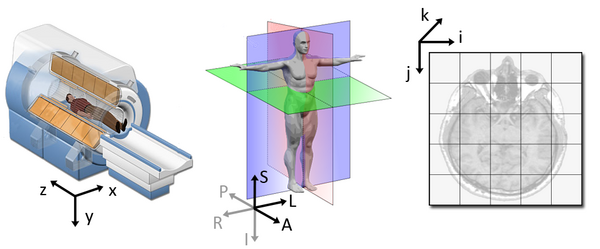

In [104]:
class_names = ['MGMT_negative', 'MGMT_positive']
num_class = len(class_names)

# all T1c file paths
image_files_list
    
num_total = len(image_files_list)
x, y, z = nib.load(data_dir + image_files_list[369]).get_fdata().shape

print(f"Total image count: {num_total}")
print(f"Image dimensions: {x} x {y} x {z}")
print(f"Label names: {class_names}")
# print(f"Label counts: {num_each}")

Total image count: 415
Image dimensions: 240 x 240 x 155
Label names: ['MGMT_negative', 'MGMT_positive']


In [105]:
# sample_nib = nib.load(data_dir + image_files_list[369])

In [106]:
# type(sample_nib)

In [107]:
sample = nib.load(data_dir + image_files_list[369]).get_fdata()


In [108]:
sample.shape

(240, 240, 155)

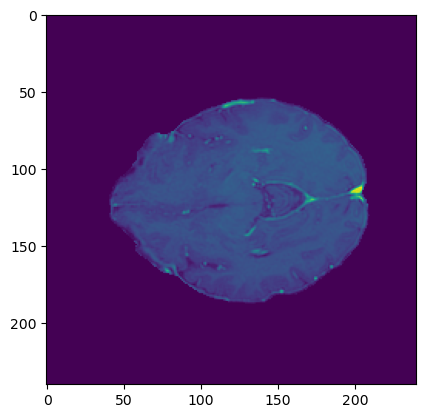

In [109]:
plt.imshow(sample[:, :, 70])

In [110]:
# resize = Resize(spatial_size = (256, 256, 64), )

In [111]:
# # pad
# pad = Pad(((0,0),(8,8),(8,8),(0,0)), 'constant', constant_values=(0))
# new_sample = pad(sample)
# print('after pad', new_sample.shape)

# # resize
# resize = Resize(spatial_size = (-1, 64))
# new_new_sample = resize(new_sample)
# print('after resize', new_new_sample.shape)

In [112]:
# test

# test transforms

In [113]:
added_c_sample = AddChannel()(sample)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


In [114]:
added_c_sample.shape

(1, 240, 240, 155)

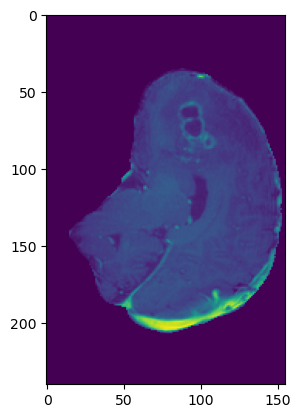

In [115]:
plt.imshow(added_c_sample[0,115, :, : ])


In [116]:
# resize = Resize(spatial_size = (256,256, 155))

In [117]:
# resized_sample = resize(added_c_sample)

In [118]:
# plt.imshow(resized_sample[0,125, :, : ])

In [119]:
# plt.imshow(resized_sample[0,:, 90, : ])

In [120]:
# 256/2


In [121]:
# spatialcrop = SpatialCrop(roi_center = (128, 128, 77), roi_size = (256, 256, 64))

In [122]:
# sc_sample = spatialcrop(resized_sample)

In [123]:
# sc_sample.shape

In [124]:
# plt.imshow(sc_sample[0,125, :, : ])

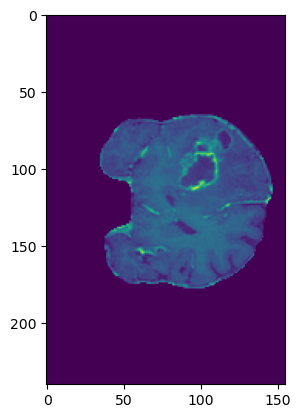

In [125]:
plt.imshow(added_c_sample[0,:, 90, : ])

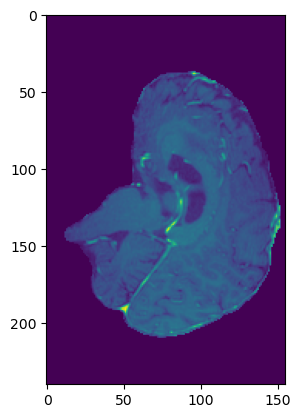

In [126]:
plt.imshow(added_c_sample[0,125, :, : ])

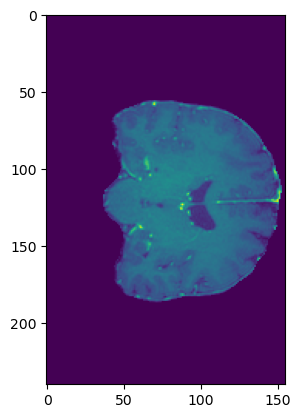

In [127]:
plt.imshow(added_c_sample[0,:,120, :])

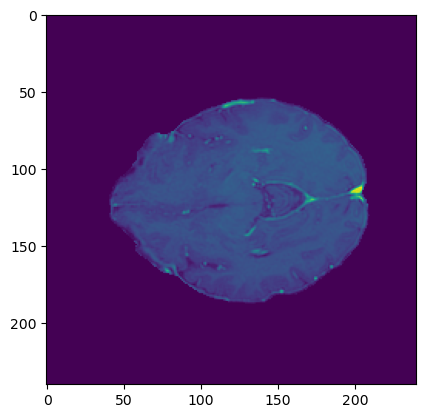

In [128]:
# after pad + resize
plt.imshow(added_c_sample[0,:,:,70])

# Transform

resize --> [1, 256, 256, 64]

In [129]:
# train_transforms = Compose(
#     [
#         LoadImage(image_only=True),
#         AddChannel(),
#         ScaleIntensity(),
#         RandRotate(range_x=15, prob=0.5, keep_size=True),
#         RandFlip(spatial_axis=0, prob=0.5),
#         RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
     
#         Resize(spatial_size = (256, 256, 64))
#         ToTensor(),
#     ]
# # )

test_transforms = Compose([LoadImage(image_only=True), 
                           AddChannel(), 
                           Pad(to_pad= ((0,0),(8,8),(8,8),(0,0)), mode ='constant', constant_values=(0)), 
                           SpatialCrop(roi_center = (128, 128, 77), roi_size = (256, 256, 64)), 
                           ScaleIntensity(), 
                           ToTensor()])

test_transforms_2 = Compose([LoadImage(image_only=True), 
                           AddChannel(), 
                           Pad(to_pad= ((0,0),(8,8),(8,8),(0,0)), mode ='constant', constant_values=(0)), 
                           SpatialCrop(roi_center = (128, 128, 77), roi_size = (256, 256, 64)), 
                        #    ScaleIntensity(), 
                           ToTensor()])


test_transforms_3 = Compose([LoadImage(image_only=True), 
                           AddChannel(), 
                           Resize(spatial_size = (256,256, 155)), 
                           SpatialCrop(roi_center = (128, 128, 77), roi_size = (256, 256, 64)), 
                           ScaleIntensity(), 
                           ToTensor()])

test_transforms_4 = Compose([LoadImage(image_only=True), 
                           AddChannel(), 
                        #    Resize(spatial_size = (256,256, 155)), 
                        #    SpatialCrop(roi_center = (128, 128, 77), roi_size = (256, 256, 64)), 
                           ScaleIntensity(), 
                           ToTensor()])

# act = Compose([EnsureType(), Activations(softmax=True)])
# to_onehot = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=num_class)])

# Reference

https://github.com/Project-MONAI/MONAIBootcamp2021/blob/main/day1/3.%20End-To-End%20Workflow%20with%20MONAI.ipynb 

# Dataset

## RNAS MICCAI

In [130]:
# batch_size = 512
# num_workers = 10

# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, image_files, labels, transforms):
#         self.image_files = image_files
#         self.labels = labels
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, index):
#         return self.transforms(self.image_files[index]), self.labels[index]


# train_ds = MedNISTDataset(train_x, train_y, train_transforms)
# train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# val_ds = MedNISTDataset(val_x, val_y, val_transforms)
# val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

# test_ds = MedNISTDataset(test_x, test_y, val_transforms)
# test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

## UCSF-PDGM

In [131]:
# image_files_list[295:300], image_class[295:300]

In [132]:
# image_files_list[410:], image_class[410:]

In [133]:
# test_x = image_files_list
# test_y = image_class

In [134]:
# run if training 
batch_size = 4
num_workers = 0

class UCSFPDGMDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, image_files, labels, transforms):
        self.image_files = [data_dir + i for i in image_files]
        self.paths = image_files
        self.labels = labels
        
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index], self.paths[index]
        # return self.image_files[index], self.labels[index], self.paths[index]



In [135]:

# test_ds = UCSFPDGMDataset(data_dir, test_x, test_y, test_transforms_4)
# test_loader = DataLoader(test_ds, num_workers=num_workers)

# Sanity Check

In [136]:
# for i in test_loader:
#     images, labels, paths = i
#     print(images.shape)
#     break

In [137]:
# plt.imshow(images[0, 0,:,:,30]),  

In [138]:
# plt.imshow(images[0, 0,150,:,:]),

In [139]:
#  plt.imshow(images[0, 0,:, 150,:])

In [140]:
import gc

gc.collect()

50

# Model

In [141]:
import datetime 
# np.save(model_result_save_path + '_preds_' + str(datetime.datetime.today().microsecond) , preds)


# Finetune with UCSF

# Train test split

In [142]:
len(image_pos_file_list), len(image_neg_file_list)

(301, 114)

In [143]:
# len(test_pos_lst), len(test_neg_lst)

In [144]:
# val_pos_x = np.random.choice(test_pos_lst, 50, replace = False)
# val_neg_x = np.random.choice(test_neg_lst, 50, replace = False)

In [145]:
keep_ratio = False

if keep_ratio:

  train_inds, val_inds, test_inds = partition_dataset_classes(np.arange(len(image_files_list)),
                                                              image_class,(8, 1, 1), shuffle=True)

  train_x = [image_files_list[i] for i in train_inds]
  train_y = [image_class[i] for i in train_inds]
  val_x = [image_files_list[i] for i in val_inds]
  val_y = [image_class[i] for i in val_inds]
  test_x = [image_files_list[i] for i in test_inds]
  test_y = [image_class[i] for i in test_inds]

  print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")

else:
  train_pos_x = np.random.choice(image_pos_file_list, 60, replace = False).tolist()
  train_neg_x = np.random.choice(image_neg_file_list, 60, replace = False).tolist()



  test_pos_lst = []
  for i in image_pos_file_list:
    if i not in train_pos_x:
      test_pos_lst.append(i)

  test_neg_lst = []
  for i in image_neg_file_list:
    if i not in train_neg_x:
      test_neg_lst.append(i)

  val_pos_x = np.random.choice(test_pos_lst, 20, replace = False).tolist()
  val_neg_x = np.random.choice(test_neg_lst, 20, replace = False).tolist()

  test_pos_x = []
  for i in image_pos_file_list:
    if i not in train_pos_x and i not in val_pos_x:
      test_pos_x.append(i)

  test_neg_x = []
  for i in image_neg_file_list:
    if i not in train_neg_x and i not in val_neg_x:
      test_neg_x.append(i)

  train_x = train_pos_x.copy()
  train_x.extend(train_neg_x)

  
  val_x = val_pos_x.copy()
  val_x.extend(val_neg_x)

  
  test_x = test_pos_x.copy()
  test_x.extend(test_neg_x)

  train_y = [1] *len(train_pos_x) + [0] * len(train_neg_x)
  val_y = [1] *len(val_pos_x) + [0] * len(val_neg_x)
  test_y = [1] *len(test_pos_x) + [0] * len(test_neg_x)

  
  print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")
  print(f"Training count: {len(train_y)}, Validation count: {len(val_y)}, Test count: {len(test_y)}")

Training count: 120, Validation count: 40, Test count: 255
Training count: 120, Validation count: 40, Test count: 255


In [146]:
len(image_files_list)

415

In [147]:
sum(test_y) / len(test_y)

0.8666666666666667

# Config

In [148]:
config = {
    'NUM_IMAGES_3D': 64,
    'TRAINING_BATCH_SIZE': 1,
    'TEST_BATCH_SIZE': 2, 
    'IMAGE_SIZE': 240,
    'N_EPOCHS': 30,
    'do_valid': True,
    'n_workers': 0,
    'lr': 1e-5
}

## Dataset and Data Loader

In [149]:
train_ds = UCSFPDGMDataset(data_dir, train_x, train_y, test_transforms_4)
train_loader = DataLoader(train_ds, num_workers=num_workers, batch_size=config['TRAINING_BATCH_SIZE'],  shuffle = True)

val_ds = UCSFPDGMDataset(data_dir, val_x, val_y, test_transforms_4)
val_loader = DataLoader(val_ds, num_workers=num_workers, batch_size=config['TRAINING_BATCH_SIZE'])

test_ds = UCSFPDGMDataset(data_dir, test_x, test_y, test_transforms_4)
test_loader = DataLoader(test_ds, num_workers=num_workers, batch_size=config['TRAINING_BATCH_SIZE'])

## Model

In [150]:
torch.cuda.empty_cache()
gc.collect()

53

In [151]:
weight_list = ['3d-resnet10_T1wCE_fold2_0.538.pth',
 '3d-resnet10_T1wCE_fold0_0.565.pth',
 '3d-resnet10_T1wCE_fold4_0.551.pth',
 '3d-resnet10_T1wCE_fold1_0.573.pth',
 '3d-resnet10_T1wCE_fold3_0.664.pth']

In [152]:
MODELPATH = '/home/ubuntu/code'

In [153]:
root_dir = '/home/ubuntu/code'

In [154]:
model_result_save_path = '/home/ubuntu/code/model_weight'

In [155]:
torch.__version__

'1.12.0'

In [156]:
from sklearn.metrics import roc_auc_score

In [157]:
RESPATH = '/home/ubuntu/code/model_weight/resnet_10.pth'
RESPATH2 = '/home/ubuntu/code/model_weight/resnet_10_23dataset.pth'

In [158]:
state_dict = torch.load(RESPATH2)['state_dict']

In [159]:
torch.load(RESPATH2)

{'state_dict': OrderedDict([('module.conv1.weight',
               tensor([[[[[ 1.4570e-01,  2.9378e-02, -1.0878e-01,  ..., -1.5268e-01,
                           -4.6321e-02, -3.4810e-03],
                          [ 2.2218e-02, -9.2343e-02, -2.1455e-01,  ..., -3.1982e-01,
                           -1.7140e-01, -8.6176e-02],
                          [-1.5188e-02, -1.5643e-01, -2.6110e-01,  ..., -2.9622e-01,
                           -1.7417e-01, -1.5549e-01],
                          ...,
                          [-6.2998e-02, -1.8581e-01, -3.0531e-01,  ..., -4.4583e-01,
                           -3.8725e-01, -3.6451e-01],
                          [-1.8084e-01, -2.8893e-01, -3.7837e-01,  ..., -5.5286e-01,
                           -5.2242e-01, -5.0610e-01],
                          [-2.2032e-01, -3.4306e-01, -4.1386e-01,  ..., -5.1591e-01,
                           -4.2092e-01, -4.9271e-01]],
               
                         [[ 2.1643e-01,  8.8735e-02, -4.6879e-02, 

In [160]:
new_state_dict = {}
for key, value in state_dict.items():
    new_state_dict[key[7:]] = value

In [161]:
new_state_dict.keys()

dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.bn2.running_mean', 'layer2.0.bn2.running_var', 'layer2.0.bn2.num_batches_tracked', 'layer2.0.downsample.0.weight', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.0.downsample.1.running_mean', 'layer2.0.downsample.1.running_var', 'layer2.0.downsample.1.num_batches_tracked', 'layer3.0.conv1.wei

In [162]:
state_dict = {'state_dict': new_state_dict}

In [163]:


pretrained_mri = False
# initiaize weight
if pretrained_mri:
    model = monai.networks.nets.resnet10(spatial_dims=3, n_input_channels=1, num_classes=1)
    model.load_state_dict(torch.load(MODELPATH + weight_list[-1]), strict=True)

model = monai.networks.nets.resnet10(spatial_dims=3, n_input_channels=1, num_classes=1)
model.load_state_dict(state_dict['state_dict'], strict = False)
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])

# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.5, last_epoch=-1, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, mode='max')


In [164]:
os.getcwd()

'/home/ubuntu/code'

In [165]:

model.zero_grad()
model.to(device)
best_loss = 9999
best_auc = 0
criterion = torch.nn.BCEWithLogitsLoss()

for epoch in range(config['N_EPOCHS']):
    print('Epoch', epoch)
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 
    tr_loss = 0.0

    model.train()

    for step, batch in enumerate(train_loader):
        
        images, targets, paths = batch
        images, targets = images.to(device), targets.to(device)
                
                
        optimizer.zero_grad()

        outputs = model(images)
        # targets = targets  # .view(-1, 1)
        # outputs = outputs.cpu().detach()
        # print('out',outputs.shape)
        # print('target', targets.float().shape)
        loss = criterion(outputs.squeeze(1), targets.float()) # output 


        # print('loss', loss.shape)
        
        loss.backward()
        optimizer.step()
        # model.zero_grad()


        tr_loss += loss.item()
        batch_bar.set_postfix(
            batch_loss=(loss.item()), loss=(tr_loss / (step + 1))
        )

        batch_bar.update()
        del images, targets, outputs
        torch.cuda.empty_cache()
   
      # Update learning rate schedule

    
    batch_bar.close()

    
    model.eval()
    val_loss = 0.0
    preds = []
    true_labels = []
    image_ids = []
    
    batch_bar_2 = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='val') 
    with torch.no_grad():
        for step, val_batch in enumerate(val_loader):

            
            val_images, val_targets, val_paths = val_batch
            val_images, val_targets = val_images.to(device), val_targets.to(device)

            val_outputs = model(val_images)
            # targets = targets  # .view(-1, 1)
            
            v_loss = criterion(val_outputs.squeeze(1), val_targets.float())
            

            val_loss += v_loss.item()

            batch_bar_2.set_postfix(
                batch_loss=(v_loss.item()), val_loss=(val_loss / (step + 1))
            )
            preds.append(val_outputs.sigmoid().cpu().detach().numpy())
            true_labels.append(val_targets.cpu().detach().numpy())
            image_ids.append(val_paths)
            del val_images, val_targets
            torch.cuda.empty_cache()
            gc.collect()
            batch_bar_2.update()
        
        batch_bar_2.close()
    

    preds = np.vstack(preds).T[0].tolist()
    true_labels = np.hstack(true_labels).tolist()
    image_ids = np.hstack(image_ids).tolist()
    auc_score = roc_auc_score(true_labels, preds)
    auc_score_adj_best = 0
    scheduler.step(auc_score)
    for thresh in np.linspace(0, 1, 50):
        auc_score_adj = roc_auc_score(true_labels, list(np.array(preds) > thresh))
        if auc_score_adj > auc_score_adj_best:
            best_thresh = thresh
            auc_score_adj_best = auc_score_adj

    
    print(
        f"EPOCH {epoch}/{config['N_EPOCHS']}: Train Loss: {tr_loss/(step+1)}, Validation average loss: {val_loss/(step+1)} + AUC SCORE = {auc_score} + AUC SCORE THRESH {best_thresh} = {auc_score_adj_best}"
    )

    if auc_score > best_auc:
        print("Saving the model...")

        # all_files = os.listdir("./weights/")

        # for f in all_files:
        #     if f"{args.model_name}_{args.type}_fold{args.fold}" in f:
        #         os.remove(f"./weights/{f}")

        best_auc = auc_score
        torch.save({
            'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
        }, model_result_save_path + f"/3d-resnet10_t1c_equalratio_maxrocauc_fromscratch_{round(best_auc,3)}.pth") # change the path

print(best_auc)

Epoch 0


val:   2%|▎         | 1/40 [00:00<00:33,  1.17it/s, batch_loss=0.657, val_loss=0.657] 

RuntimeError: CUDA out of memory. Tried to allocate 70.00 MiB (GPU 0; 14.56 GiB total capacity; 13.42 GiB already allocated; 14.44 MiB free; 13.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Inference

In [ ]:
for i in test_loader:
  print(i)
  break

[tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
          

In [ ]:
os.listdir('/content/drive/MyDrive/02718 Project/Model Outputs/ResNet/')


['3d-resnet10_t1c_fold_0.582.pth',
 '3d-resnet10_t1c_fold_0.542.pth',
 '3d-resnet10_t1c_fold_0.455.pth',
 '3d-resnet10_t1c_fold_0.579.pth',
 '3d-resnet10_t1c_fold_0.588.pth',
 '3d-resnet10_t1c_fold_0.682.pth',
 '3d-resnet10_t1c_fold_0.733.pth',
 '3d-resnet10_t1c_fold_0.748.pth',
 '3d-resnet10_t1c_fold_0.764.pth',
 '3d-resnet10_t1c_equalratio_0.521.pth']

In [ ]:
# after finetune

finetune_weight_list = ['3d-resnet10_t1c_equalratio_0.521.pth',
 '3d-resnet10_t1c_fold_0.582.pth',
 '3d-resnet10_t1c_fold_0.542.pth',
 '3d-resnet10_t1c_fold_0.455.pth',
 '3d-resnet10_t1c_fold_0.579.pth',
 '3d-resnet10_t1c_fold_0.588.pth',
 '3d-resnet10_t1c_fold_0.682.pth',
 '3d-resnet10_t1c_fold_0.733.pth',
 '3d-resnet10_t1c_fold_0.748.pth',
 '3d-resnet10_t1c_fold_0.764.pth']

In [ ]:
# prertrained weight
pretrained_weight_list = ['3d-resnet10_T1wCE_fold2_0.538.pth',
 '3d-resnet10_T1wCE_fold0_0.565.pth',
 '3d-resnet10_T1wCE_fold4_0.551.pth',
 '3d-resnet10_T1wCE_fold1_0.573.pth',
 '3d-resnet10_T1wCE_fold3_0.664.pth']

In [ ]:
finetune = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


if finetune:
  CHECKPOINTPATH = '/content/drive/MyDrive/02718 Project/Model Outputs/ResNet/3d-resnet10_t1c_equalratio_0.521.pth'

  # load model 
  model = monai.networks.nets.resnet10(spatial_dims=3, n_input_channels=1, num_classes=1).to(device)
  checkpoint = torch.load(CHECKPOINTPATH)
  model.load_state_dict(checkpoint["model_state_dict"])

else:
  MODELPATH = '/content/drive/MyDrive/02718 Project/Model Weights/'
  model = monai.networks.nets.resnet10(spatial_dims=3, n_input_channels=1, num_classes=1).to(device)
  model.load_state_dict(torch.load(MODELPATH + pretrained_weight_list[0]), strict=True)


cuda:0


In [ ]:
# prediction using finetune
if finetune:
  tta_true_labels = []
  tta_preds = []


  preds_f = np.zeros(len(test_y))

  image_ids = []
  labels_lst = []
  preds = []

  with torch.no_grad():
      for  step, batch in enumerate(test_loader):
          model.eval()
          images, labels, paths = batch

          images = images.cuda()
          # change the weight 

          outputs = model(images)
          preds.append(outputs.sigmoid().detach().cpu().numpy())
          labels_lst.append(labels.detach().cpu().numpy())
          image_ids.append(paths)


# prediction using pretrained
else: 
  tta_true_labels = []
  tta_preds = []


  preds_f = np.zeros(len(test_y))
  for fold in range(5):
      image_ids = []
      labels_lst = []
      preds = []

      with torch.no_grad():
          for  step, batch in enumerate(test_loader):
              model.eval()
              images, labels, paths = batch

              images = images.cuda()
              model.load_state_dict(torch.load(MODELPATH + pretrained_weight_list[fold]), strict=True)

              outputs = model(images)
              preds.append(outputs.sigmoid().detach().cpu().numpy())
              labels_lst.append(labels.detach().cpu().item())
              image_ids.append(paths)
      

      preds_f += np.vstack(preds).T[0]/5

      # ids_f = np.hstack(image_ids)


In [ ]:
preds[0].flatten().tolist()


[0.4987565875053406, 0.37354135513305664]

In [ ]:
new_preds_lst = []
for i in range(len(preds)):
  new_preds_lst.extend(preds[i].flatten().tolist())


In [ ]:
new_preds_lst

[0.4987565875053406,
 0.37354135513305664,
 0.5057792067527771,
 0.44111117720603943,
 0.5197410583496094,
 0.4532737731933594,
 0.3949871063232422,
 0.443866491317749,
 0.4949023127555847,
 0.5155504941940308,
 0.44997501373291016,
 0.4868710935115814,
 0.4360673725605011,
 0.4944859445095062,
 0.4700569808483124,
 0.4380270540714264,
 0.3796958923339844,
 0.48225945234298706,
 0.2950184643268585,
 0.45967766642570496,
 0.4953511953353882,
 0.5175939798355103,
 0.5015513300895691,
 0.4136379659175873,
 0.5119695663452148,
 0.5071343779563904,
 0.4834177494049072,
 0.44974085688591003,
 0.5106974244117737,
 0.49690699577331543,
 0.49736884236335754,
 0.4919421970844269,
 0.47363176941871643,
 0.4952215850353241,
 0.4501819610595703,
 0.48067882657051086,
 0.4839203953742981,
 0.4823244512081146,
 0.4583853781223297,
 0.4479300379753113,
 0.5074447393417358,
 0.5064758062362671,
 0.507158637046814,
 0.4324888288974762,
 0.5052967667579651,
 0.4789855480194092,
 0.5179383158683777,
 0.46

In [ ]:

# pred_lst = preds.copy()
# new_preds = [pred_lst[i].item() for i in range(len(pred_lst))]

In [ ]:
new_labels_lst = []
for i in range(len(labels_lst)):
  new_labels_lst.extend(labels_lst[i].tolist())

In [ ]:
new_labels_lst

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
if finetune:
  df = pd.DataFrame({'predicted': new_preds_lst, 'labels': new_labels_lst})
else:
  df = pd.DataFrame({'predicted': preds_f, 'labels': labels_lst})

In [ ]:
df

,predicted,labels
0,0.498757,1
1,0.373541,1
2,0.505779,1
3,0.441111,1
4,0.519741,1
...,...,...
210,0.161437,0
211,0.372076,0
212,0.410299,0
213,0.450842,0


In [ ]:
df[df['labels'] == 1]['predicted'].describe()

count    201.000000
mean       0.395338
std        0.098036
min        0.056756
25%        0.352218
50%        0.410581
75%        0.472366
max        0.519741
Name: predicted, dtype: float64

In [ ]:
df[df['labels'] == 0]['predicted'].describe()

count    14.000000
mean      0.420560
std       0.088344
min       0.161437
25%       0.415460
50%       0.442444
75%       0.473704
max       0.501535
Name: predicted, dtype: float64

In [ ]:
df.to_csv('/content/drive/MyDrive/02718 Project/Model Outputs/df_pred_finetuned_equalratio_1.csv', index=False)

In [ ]:
threshold = 0.4

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(new_labels_lst, (np.array(new_preds_lst)))

0.41186922530206116

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
if finetune:
  print(classification_report(new_labels_lst, (np.array(new_preds_lst)>threshold)))

else:
  print(classification_report(labels_lst, (preds_f>0.5)))

              precision    recall  f1-score   support

           0       0.03      0.21      0.06        14
           1       0.91      0.56      0.69       201

    accuracy                           0.53       215
   macro avg       0.47      0.39      0.37       215
weighted avg       0.85      0.53      0.65       215

